# Real Data Example

(Estimation and Inference for Nonparametric Expected Shortfall Regression over RKHS)

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy.random as rgt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from utl import *

## 2. Exploratory Data Analysis

We conduct a preliminary exploratory data analysis, including box plots of PM2.5 concentrations (in $\mu g/m^3$) from 12 monitoring stations and a kernel density estimation of PM2.5 concentrations (in $\mu g/m^3$) for $\texttt{Aotizhongxin}$.

### 2.1 Box plots

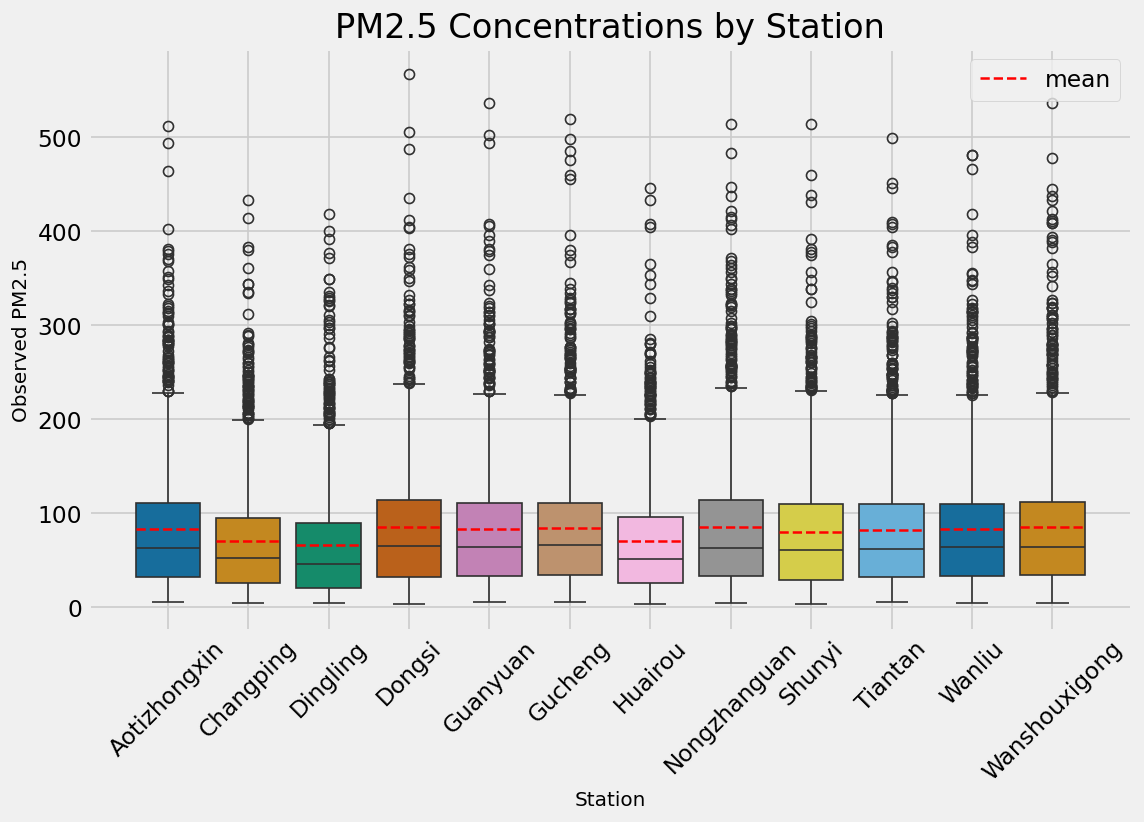

In [2]:
# load the data
df1 = pd.read_csv('dataset/Aotizhongxin.csv')
df2 = pd.read_csv('dataset/Changping.csv')
df3 = pd.read_csv('dataset/Dingling.csv')
df4 = pd.read_csv('dataset/Dongsi.csv')
df5 = pd.read_csv('dataset/Guanyuan.csv')
df6 = pd.read_csv('dataset/Gucheng.csv')
df7 = pd.read_csv('dataset/Huairou.csv')
df8 = pd.read_csv('dataset/Nongzhanguan.csv')
df9 = pd.read_csv('dataset/Shunyi.csv')
df10 = pd.read_csv('dataset/Tiantan.csv')
df11 = pd.read_csv('dataset/Wanliu.csv')
df12 = pd.read_csv('dataset/Wanshouxigong.csv')


# list of DataFrames and corresponding station names
dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12]
stations = ['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 
            'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 
            'Shunyi', 'Tiantan', 'Wanliu', 'Wanshouxigong']

# concatenate the DataFrames along the rows
for df, station in zip(dfs, stations):
    df['station'] = station

commcol = set(dfs[0].columns)
for df in dfs[1:]:
    commcol.intersection_update(df.columns)
commcol = list(commcol)
combined_df = pd.concat([df[commcol] for df in dfs], ignore_index=True)

# draw box plots
plt.figure(figsize=(10, 6), dpi=120)
sns.boxplot(x='station', y='PM2.5', data=combined_df, 
            hue='station', palette='colorblind', legend=False)

# draw mean lines
mean_values = combined_df.groupby('station')['PM2.5'].mean()
for i, mean in enumerate(mean_values):
    plt.plot([i-0.4, i+0.4], [mean, mean], color='red', 
             linestyle='dashed', linewidth=1.5, zorder=5, 
             label='mean' if i == 0 else "")

# final touches
plt.legend()
plt.xlabel('Station', fontsize=12)
plt.ylabel('Observed PM2.5', fontsize=12)
plt.xticks(rotation=45)
plt.title('PM2.5 Concentrations by Station')
plt.grid(True)
plt.show()

### 2.2 Kernel density estimation

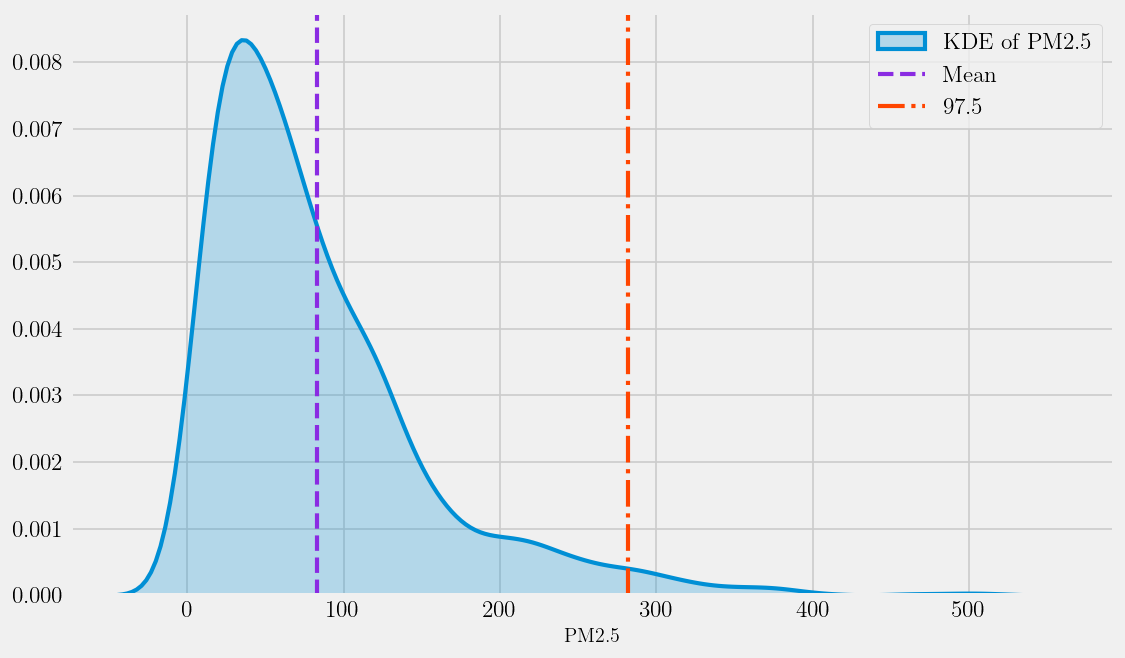

In [3]:
# load the data
df = pd.read_csv('dataset/Aotizhongxin.csv')
y = df['PM2.5'].values
columns_to_drop = ['year', 'month', 'day', 'PM2.5', 'RAIN', 'season']
X = df.drop(columns=columns_to_drop)

# write the feature names in teletype font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  
})

feature_names = [r'$\texttt{SO}_2$', r'$\texttt{NO}_2$', r'$\texttt{CO}$', 
                 r'$\texttt{O}_3$', r'$\texttt{TEMP}$', r'$\texttt{PRES}$', 
                 r'$\texttt{DEWP}$', r'$\texttt{WSPM}$']

n_feature = len(feature_names) # number of features

# draw the kernel density estimator of PM2.5
plt.figure(figsize=(10, 6), dpi=120)
plt.style.use(plt.style.available[8])
sns.kdeplot(y, linewidth=2.5, bw_adjust=1,
            fill=True, label='KDE of PM2.5')
plt.axvline(np.mean(y), color='blueviolet', 
            linestyle='--', linewidth=2.5, label='Mean')
plt.axvline(np.quantile(y, 0.975), color='orangered',
            linestyle='-.', linewidth=2.5, label='97.5%-quantile')
plt.xlabel('PM2.5', fontsize=12)
plt.ylabel('')
plt.legend()
plt.show()

## 3. Compute VPIs

Compute the VPIs for the mean regression, 10% upper ES regression, 5% upper ES regression, and 2.5% upper ES regression. To alleviate the effects of random splits in cross-validation, we repeat the estimation and VPI calculation 50 times.

### Setting and functions

In [4]:
rgt.seed(0)
grid_q = 10**np.linspace(-5, -3, 10) # a grid of ridge penalty levels for quantile-KRR
grid_e = 10**np.linspace(-3, 0, 20) # a grid of ridge penalty levels for ES-KRR
grid = 10**np.linspace(-5, -2, 20) # a grid of ridge penalty levels for KRR
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.copy()) # scale the features

B = 50 # number of repetitions

In [5]:
# VPI calculation for ES KRR regression
def es_vpi(i, tau):
    # 5-fold cross-validation for quantile-KRR
    step1 = CV_Qt_KR(X_scaled, -y, tau, 'rbf', grid_q, kernel_params={'gamma': 0.5}, 
                     nfolds=5, random_state=i, solver='cvxopt', smooth=False, tol=1e-8)
    alpha_q = step1['alpha_q']
    
    # 5-fold cross-validation for ES-KRR
    step2 = CV_ES_KR(X_scaled, -y, tau, 'rbf', alpha_q, grid_e, kernel_params={'gamma': 0.5}, 
                     nfolds=5, random_state=i, solver='cvxopt', smooth=False, tol=1e-8)
    model = step2['model']

    z = np.minimum(-y - model.fit_q, 0)/tau + model.fit_q
    es_pred = model.fit_e
    vpi = np.zeros(n_feature)
    
    # compute the VPI for each feature
    for j in range(n_feature):
        X_tmp = X_scaled.copy()
        X_tmp[:,j] = rgt.permutation(X_tmp[:,j]) # permute the j-th feature
        es_pred_temp = model.model_e.predict(X_tmp) 
        vpi[j] = (np.mean((es_pred_temp - z)**2)/np.mean((es_pred - z)**2)) - 1 # compute the VPI
    
    return vpi

In [6]:
# VPI calculation for mean KRR regression
def mean_vpi(i):
    # KRR with 5-fold cross-validation
    cv = CV_KR(X_scaled, y, 'rbf', grid, 
               kernel_params={'gamma': 0.5}, nfolds=5, random_state=i)
    model = cv['model']
    y_pred = model.predict(X_scaled)
    vpi = np.zeros(n_feature)

    # compute the VPI for each feature
    for j in range(n_feature):
        X_tmp = X_scaled.copy()
        X_tmp[:, j] = rgt.permutation(X_tmp[:, j]) # permute the j-th feature
        y_pred_tmp = model.predict(X_tmp)
        vpi[j] = (np.mean((y_pred_tmp - y)**2)/np.mean((y_pred - y)**2)) - 1 # compute the VPI
    
    return vpi

### 3.1 VPIs for mean regression

### Start simulations

In [10]:
vpi1 = np.array(Parallel(n_jobs=-1)(delayed(mean_vpi)(i)
                                    for i in tqdm(range(B))))

  0%|          | 0/50 [00:00<?, ?it/s]

### Plot results

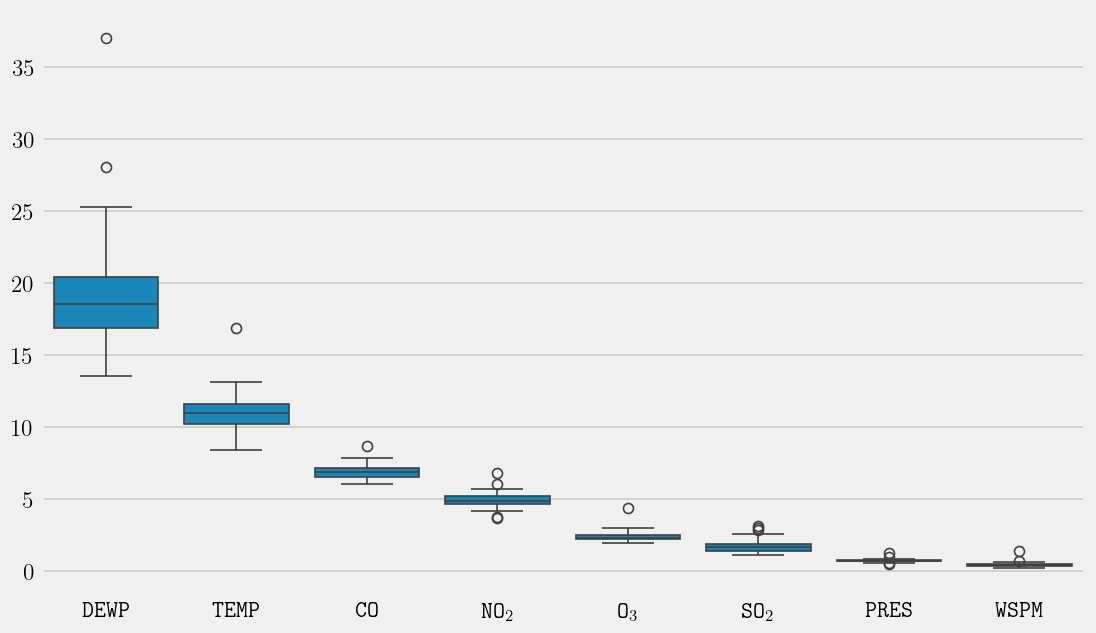

In [11]:
vpi1_df = pd.DataFrame(vpi1, columns=feature_names)
mean_vpi1 = vpi1_df.mean(axis = 0)
sorted_columns = mean_vpi1.sort_values(ascending=False).index
ES_vpi_sorted = vpi1_df[sorted_columns]
mean_vpi_melted = ES_vpi_sorted.melt(var_name='Feature', value_name='Value')

# Plotting the box plot
plt.figure(figsize=(10, 6), dpi=120)
sns.boxplot(x='Feature', y='Value', data=mean_vpi_melted)
plt.xticks(range(len(sorted_columns)), sorted_columns)
plt.xlabel('')
plt.ylabel('')
plt.show()

### 3.2 VPIs for 10% upper ES regression

### Start simulations

In [12]:
tau = 0.1 # quantile level
vpi2 = np.array(Parallel(n_jobs=-1)(delayed(es_vpi)(i,tau)
                                    for i in tqdm(range(B))))

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Plot results

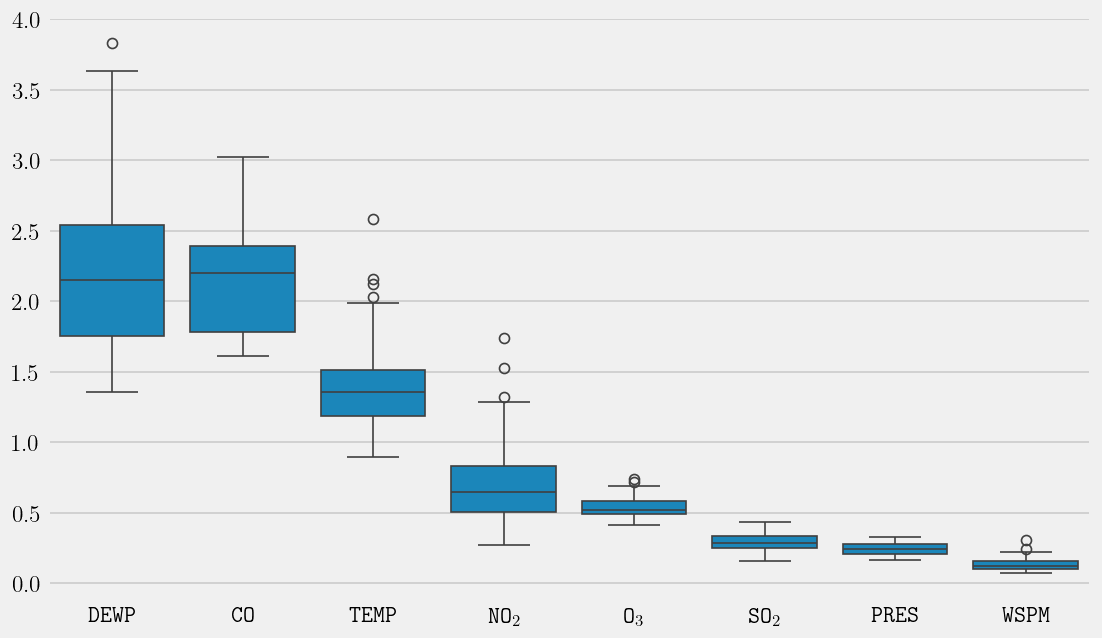

In [14]:
vpi2_df = pd.DataFrame(vpi2, columns=feature_names)
mean_vpi2 = vpi2_df.mean(axis = 0)
sorted_columns = mean_vpi2.sort_values(ascending=False).index
ES_vpi_sorted = vpi2_df[sorted_columns]
mean_vpi_melted = ES_vpi_sorted.melt(var_name='Feature', value_name='Value')

# Plotting the box plot
plt.figure(figsize=(10, 6), dpi=120)
sns.boxplot(x='Feature', y='Value', data=mean_vpi_melted)
plt.xticks(range(len(sorted_columns)), sorted_columns)
plt.xlabel('')
plt.ylabel('')
plt.show()

### 3.3 VPIs for 5% upper ES regression

### Start simulations

In [15]:
tau = 0.05 # quantile level
vpi3 = np.array(Parallel(n_jobs=-1)(delayed(es_vpi)(i,tau)
                                    for i in tqdm(range(B))))

  0%|          | 0/50 [00:00<?, ?it/s]

### Plot results

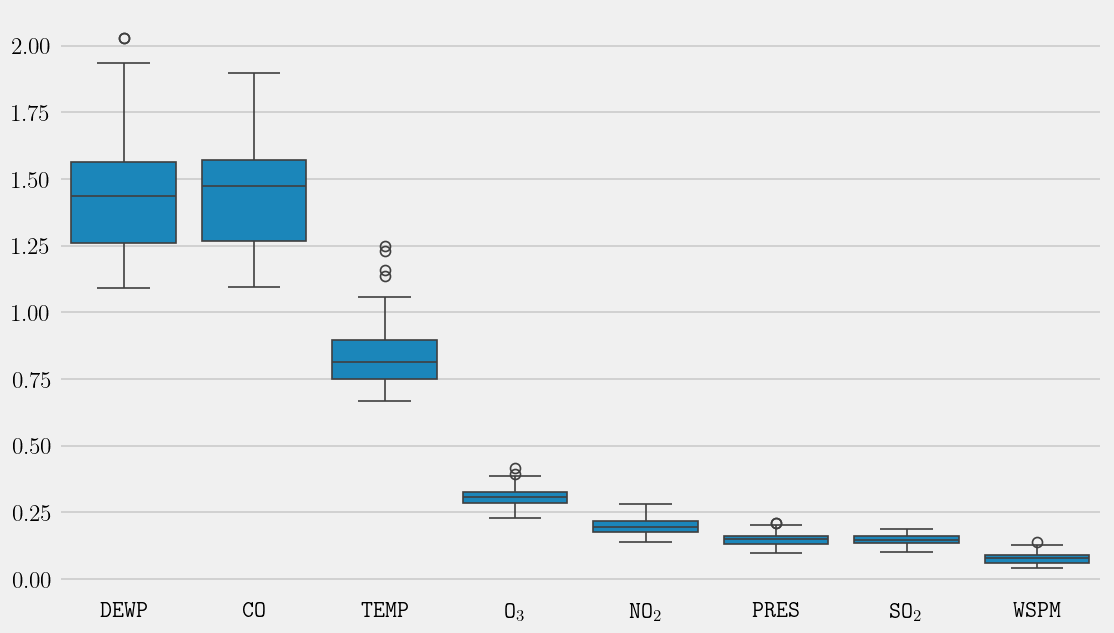

In [17]:
vpi3_df = pd.DataFrame(vpi3, columns=feature_names)
mean_vpi3 = vpi3_df.mean(axis = 0)
sorted_columns = mean_vpi3.sort_values(ascending=False).index
ES_vpi_sorted = vpi3_df[sorted_columns]
mean_vpi_melted = ES_vpi_sorted.melt(var_name='Feature', value_name='Value')

# Plotting the box plot
plt.figure(figsize=(10, 6), dpi=120)
sns.boxplot(x='Feature', y='Value', data=mean_vpi_melted)
plt.xticks(range(len(sorted_columns)), sorted_columns)
plt.xlabel('')
plt.ylabel('')
plt.show()

### 3.4 VPIs for 2.5% upper ES regression

### Start simulations

In [18]:
tau = 0.025 # quantile level
vpi4 = np.array(Parallel(n_jobs=-1)(delayed(es_vpi)(i,tau)
                                    for i in tqdm(range(B))))

  0%|          | 0/50 [00:00<?, ?it/s]

### Plot results

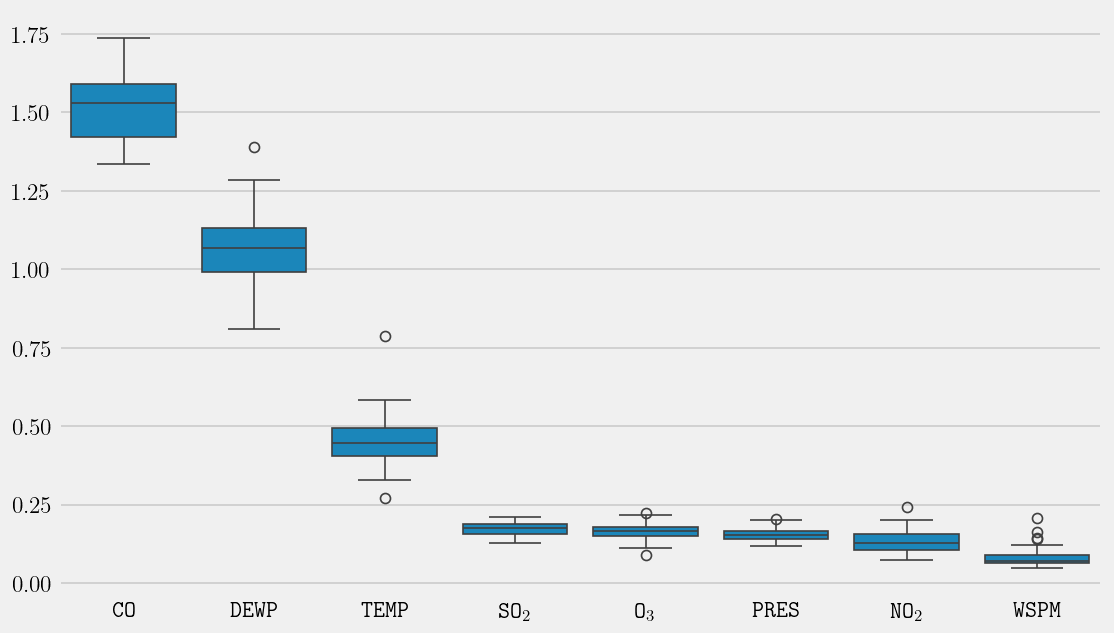

In [19]:
vpi4_df = pd.DataFrame(vpi4, columns=feature_names)
mean_vpi4 = vpi4_df.mean(axis = 0)
sorted_columns = mean_vpi4.sort_values(ascending=False).index
ES_vpi_sorted = vpi4_df[sorted_columns]
mean_vpi_melted = ES_vpi_sorted.melt(var_name='Feature', value_name='Value')

# Plotting the box plot
plt.figure(figsize=(10, 6), dpi=120)
sns.boxplot(x='Feature', y='Value', data=mean_vpi_melted)
plt.xticks(range(len(sorted_columns)), sorted_columns)
plt.xlabel('')
plt.ylabel('')
plt.show()

# End